In [1]:
%matplotlib inline
%load_ext autoreload


import torch
import torch.nn.functional as F
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
from laughter_classification.sspnet_data_sampler import SSPNetDataSampler
from laughter_prediction.feature_extractors import LibrosaExtractor
from sklearn.model_selection import train_test_split
from laughter_prediction.rnn import LibrosaFeaturesRnn
from laughter_prediction.predictors import RnnPredictor
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import matplotlib.pyplot as plt

In [2]:
!mkdir -p data

## Cмотирим на данные

In [3]:
directory = 'vocalizationcorpus/data'
audio_files = list(sorted(os.listdir('vocalizationcorpus/data')))

audio_file = directory + '/' + audio_files[0]
audio_file

'vocalizationcorpus/data/S0001.wav'

(128, 474)


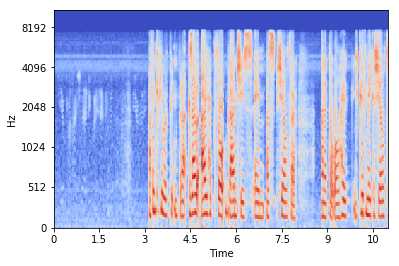

In [4]:
y, sr = librosa.load(audio_file)
S = librosa.feature.melspectrogram(y, sr)
S = librosa.power_to_db(S)

print(S.shape)
librosa.display.specshow(S, sr=sr, x_axis='time', y_axis='mel')

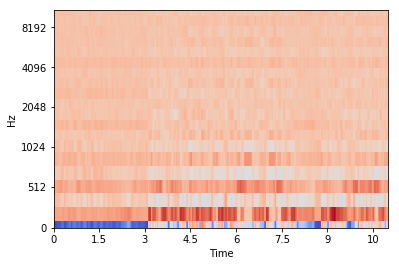

In [5]:
y, sr = librosa.load(audio_file)
S = librosa.feature.mfcc(y, sr)
librosa.display.specshow(S, sr=sr, x_axis='time', y_axis='mel')

In [6]:
extractor = LibrosaExtractor()
extractor.extract_features(audio_file).head()

,fbank_000,fbank_001,fbank_002,fbank_003,fbank_004,fbank_005,fbank_006,fbank_007,fbank_008,fbank_009,...,mfcc_010,mfcc_011,mfcc_012,mfcc_013,mfcc_014,mfcc_015,mfcc_016,mfcc_017,mfcc_018,mfcc_019
0,-14.770546,-7.502573,-14.677981,-10.937127,-21.269282,-39.300535,-43.299913,-38.613908,-20.862417,-16.210959,...,7.274429,11.029847,10.672556,-0.565825,19.375721,1.419888,6.978270,-2.037510,20.511622,8.859711
1,-16.770523,-8.677541,-18.883031,-33.635306,-29.146382,-23.314792,-15.536017,-10.014064,-25.719489,-35.669000,...,-16.901669,-7.184055,-19.194132,-17.970590,12.663122,-0.107084,20.268938,1.372494,-7.076095,8.931564
2,-12.352719,-4.444362,-14.673733,-42.556730,-17.731121,-11.759801,-19.046962,-15.194353,-23.255466,-19.323618,...,-11.666725,2.564224,-4.208590,-11.211039,16.965807,16.649665,23.453795,11.212921,9.460361,-13.224893
3,-15.440580,-7.917505,-18.145880,-45.599949,-29.652522,-23.691098,-19.468875,-14.010716,-25.302332,-22.604453,...,-0.191644,9.514174,-7.796018,-7.132752,11.623116,8.058064,21.677039,-1.138147,-2.169490,-5.259990
4,-18.958624,-11.360067,-18.807546,-15.593530,-23.763246,-21.985535,-24.705120,-19.680730,-22.500579,-18.102045,...,-14.405206,-4.518877,4.056877,6.588490,14.185785,-15.692512,3.539914,12.142542,9.761851,3.887359


In [ ]:
## Считываем признаки

In [7]:
SAMPLE_RATE = 16000
FRAME_SEC = 0.3

In [8]:
sampler = SSPNetDataSampler('vocalizationcorpus')

In [9]:
data = sampler.create_sampled_df(FRAME_SEC, save_path='data/sampled.csv')

/home/maxim/PycharmProjects/speech-ml-hw/2/homework/laughter_classification/sspnet_data_sampler.py:111: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  return pd.DataFrame.from_csv(save_path, index_col=None)


In [10]:
data

,fbank_000,fbank_001,fbank_002,fbank_003,fbank_004,fbank_005,fbank_006,fbank_007,fbank_008,fbank_009,...,mfcc_012,mfcc_013,mfcc_014,mfcc_015,mfcc_016,mfcc_017,mfcc_018,mfcc_019,IS_LAUGHTER,SNAME
0,-1.822273,-4.153107,-6.127165,-4.744270,-3.042214,-1.339390,3.440107,12.049357,18.508058,18.495235,...,-3.279198,-7.744685,13.188406,-15.828284,-2.788314,-6.735201,-0.648314,-2.205029,0,S0883
1,-15.560526,-12.192421,-17.653885,-19.870362,-14.625828,-18.043698,-17.459772,-15.043800,-15.155906,-14.942318,...,2.968277,-3.823424,7.782831,-10.649842,12.054846,-16.101373,7.706882,7.032740,0,S0883
2,-13.402336,-9.324762,-11.337922,-13.557925,-11.274661,-11.788429,-12.618071,-13.004464,-12.791547,-12.865611,...,10.503806,-3.110308,16.844341,-16.793098,9.245858,-12.490855,1.376820,-1.481758,0,S0883
3,-15.991697,-11.128731,-14.647389,-14.145352,-10.337301,-8.605968,-6.843310,-8.546107,-9.693120,-10.963831,...,15.545574,-3.590542,14.474457,-15.913445,2.790456,-15.866880,-1.439778,-4.094808,0,S0883
4,-16.955938,-13.346069,-15.512038,-17.894600,-18.070054,-17.828938,-16.749832,-16.722315,-19.911563,-19.673532,...,5.920388,-4.687736,15.792177,-13.221612,13.721047,-13.489680,9.807748,-2.527528,0,S0883
5,0.646691,-5.498471,-6.820034,-8.193006,-7.084161,-3.792549,-1.219193,11.592491,17.865859,15.925368,...,-2.049894,-14.379304,3.403395,-12.829240,2.768446,-5.736103,3.966473,0.461561,0,S0883
6,-6.284641,-4.476452,-4.508171,-5.953777,-6.800229,-4.671392,-0.456830,3.798520,3.489447,4.283108,...,7.559780,-1.081865,0.940473,-14.494771,1.262333,-2.956683,-4.423065,3.032808,0,S0883
7,-15.978457,-12.014055,-19.023314,-23.477487,-19.386470,-20.043930,-20.530321,-19.775818,-20.583855,-20.342087,...,12.887851,-2.703269,14.150279,-16.079925,19.098814,-9.557634,4.102285,-1.883761,0,S0883
8,-16.920980,-13.219841,-16.037795,-18.457891,-18.815624,-15.650121,-14.958242,-15.178341,-16.562365,-18.883285,...,1.705320,-2.482357,11.217743,-20.793836,9.347085,-12.347605,10.098329,-2.900409,0,S0883
9,-15.483795,-11.250385,-14.363998,-15.435853,-15.122773,-16.479205,-16.355765,-15.626713,-14.124518,-13.873653,...,9.564394,-11.874891,9.189812,-19.225750,9.891422,-9.940770,13.255929,-2.335170,0,S0883


In [ ]:
sampler_noisy = SSPNetDataSampler('vocalizationcorpus_noisy/vocalizationcorpus')
data_noisy = sampler_noisy.create_sampled_df(FRAME_SEC, save_path='data/sampled_noisy.csv')

iter 4/2735 7.199583292007446
iter 8/2735 11.984560012817383
iter 16/2735 21.745217084884644
iter 32/2735 40.75918912887573
iter 64/2735 78.5109076499939
iter 128/2735 155.3822784423828
iter 256/2735 318.8473026752472
iter 512/2735 661.497350692749


In [12]:
data_noisy

,fbank_000,fbank_001,fbank_002,fbank_003,fbank_004,fbank_005,fbank_006,fbank_007,fbank_008,fbank_009,...,mfcc_012,mfcc_013,mfcc_014,mfcc_015,mfcc_016,mfcc_017,mfcc_018,mfcc_019,IS_LAUGHTER,SNAME
0,-1.822273,-4.153107,-6.127165,-4.744270,-3.042214,-1.339390,3.440107,12.049357,18.508058,18.495235,...,-3.279198,-7.744685,13.188406,-15.828284,-2.788314,-6.735201,-0.648314,-2.205029,0,S0883
1,-15.560526,-12.192421,-17.653885,-19.870362,-14.625828,-18.043698,-17.459772,-15.043800,-15.155906,-14.942318,...,2.968277,-3.823424,7.782831,-10.649842,12.054846,-16.101373,7.706882,7.032740,0,S0883
2,-13.402336,-9.324762,-11.337922,-13.557925,-11.274661,-11.788429,-12.618071,-13.004464,-12.791547,-12.865611,...,10.503806,-3.110308,16.844341,-16.793098,9.245858,-12.490855,1.376820,-1.481758,0,S0883
3,-15.991697,-11.128731,-14.647389,-14.145352,-10.337301,-8.605968,-6.843310,-8.546107,-9.693120,-10.963831,...,15.545574,-3.590542,14.474457,-15.913445,2.790456,-15.866880,-1.439778,-4.094808,0,S0883
4,-16.955938,-13.346069,-15.512038,-17.894600,-18.070054,-17.828938,-16.749832,-16.722315,-19.911563,-19.673532,...,5.920388,-4.687736,15.792177,-13.221612,13.721047,-13.489680,9.807748,-2.527528,0,S0883
5,0.646691,-5.498471,-6.820034,-8.193006,-7.084161,-3.792549,-1.219193,11.592491,17.865859,15.925368,...,-2.049894,-14.379304,3.403395,-12.829240,2.768446,-5.736103,3.966473,0.461561,0,S0883
6,-6.284641,-4.476452,-4.508171,-5.953777,-6.800229,-4.671392,-0.456830,3.798520,3.489447,4.283108,...,7.559780,-1.081865,0.940473,-14.494771,1.262333,-2.956683,-4.423065,3.032808,0,S0883
7,-15.978457,-12.014055,-19.023314,-23.477487,-19.386470,-20.043930,-20.530321,-19.775818,-20.583855,-20.342087,...,12.887851,-2.703269,14.150279,-16.079925,19.098814,-9.557634,4.102285,-1.883761,0,S0883
8,-16.920980,-13.219841,-16.037795,-18.457891,-18.815624,-15.650121,-14.958242,-15.178341,-16.562365,-18.883285,...,1.705320,-2.482357,11.217743,-20.793836,9.347085,-12.347605,10.098329,-2.900409,0,S0883
9,-15.483795,-11.250385,-14.363998,-15.435853,-15.122773,-16.479205,-16.355765,-15.626713,-14.124518,-13.873653,...,9.564394,-11.874891,9.189812,-19.225750,9.891422,-9.940770,13.255929,-2.335170,0,S0883


In [13]:
def split(df, test_size=0.1, seed=0):
    np.random.seed(seed)
    df.sort_values('SNAME')
    df_by_sname = df.groupby('SNAME')
    
    records = [record for _, record in df_by_sname]
    snames  = [sname  for sname, _ in df_by_sname]
    y = [record['IS_LAUGHTER'] for record in records]
    X = [record.drop(['IS_LAUGHTER', 'SNAME'], axis=1) for record in records]
    
    y = np.array(y)
    X = np.array([x_df.values for x_df in X], dtype=np.float)
    
    X_train, X_test, y_train, y_test, snames_train, snames_test = \
        train_test_split(X, y, snames, train_size=1. - test_size, test_size=test_size)
    return  X_train, X_test, y_train, y_test, snames_train, snames_test

In [14]:
X_train, X_test, y_train, y_test, snames_train, snames_test = split(data_noisy)

In [15]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2461, 36, 148) (274, 36, 148) (2461, 36) (274, 36)


In [16]:
print(y_train[0], snames_train[0])

pd.DataFrame(X_train[0], columns=data.columns[:-2]).head()

[0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] S2336


,fbank_000,fbank_001,fbank_002,fbank_003,fbank_004,fbank_005,fbank_006,fbank_007,fbank_008,fbank_009,...,mfcc_010,mfcc_011,mfcc_012,mfcc_013,mfcc_014,mfcc_015,mfcc_016,mfcc_017,mfcc_018,mfcc_019
0,-18.279837,-9.925743,-7.034727,-6.366470,-3.582562,-1.967274,-2.186619,-2.898087,-3.289914,-0.819692,...,-1.169253,-17.384172,7.527737,-6.033273,7.701181,-23.957190,3.767768,1.823572,-9.087695,-6.310789
1,-8.350764,-5.838239,-12.176471,-14.766308,-9.684821,-6.898449,-8.555903,-6.893569,-8.804226,-9.584676,...,8.890739,-5.229507,-4.702625,0.386777,3.939774,-18.231355,2.193106,4.371894,9.123777,-3.683551
2,11.359923,12.165919,11.480765,10.722380,12.210117,10.033398,12.812613,19.312832,21.964445,20.846574,...,-4.888039,-7.816252,4.843390,-13.938502,14.086315,-21.263040,7.924920,-1.231396,-1.357336,-1.102332
3,9.336116,12.117546,12.854618,10.236182,10.263695,8.408460,15.811200,21.591474,21.708506,18.546723,...,-4.029900,-9.275778,2.575881,-9.233933,17.619638,-24.482254,1.947509,4.696934,-10.371555,-4.077387
4,-12.269389,-8.890475,-14.250389,-14.873047,-13.767618,-12.472830,-11.756094,-8.592509,-7.110627,-6.701631,...,11.078050,-9.460352,-4.329575,0.001802,15.019187,-29.359874,13.769583,1.476259,-5.777022,-4.519862


## Обучаем модель на данных с шумом

In [17]:
fbank_features = sum(1 for col in data_noisy.columns if col.startswith('fbank'))
mfcc_features = sum(1 for col in data_noisy.columns  if col.startswith('mfcc'))
hidden_size = 100
batch_size = 1024
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
fbank_features, mfcc_features, hidden_size, batch_size, device

(128, 20, 100, 1024, 'cuda')

In [19]:
def window_mean(arr, k=5):
    return np.convolve(arr,np.ones(k, dtype=float) / k,'valid')

In [20]:
class LearningStats:
    def __init__(self):
        self.train_losses = []
        self.test_losses = []
        self.test_auc = []
        self.train_auc = []
        self.test_f1 = []
        self.train_f1 = []
        
    def plot(self):
        plt.plot(window_mean(self.train_losses), label='train_loss')
        plt.plot(window_mean(self.test_losses), label='test_loss')
        plt.legend()
        plt.show()

        plt.plot(window_mean(self.train_auc), label='train_auc')
        plt.plot(window_mean(self.test_auc), label='test_auc')
        plt.legend()
        plt.show()
        
        plt.plot(window_mean(self.train_f1), label='train_f1')
        plt.plot(window_mean(self.test_f1), label='test_f1')
        plt.legend()
        plt.show()

In [21]:
model_noisy = LibrosaFeaturesRnn(fbank_features, mfcc_features, 
                           hidden_size=hidden_size,
                           batch_size=batch_size)

model_noisy = model_noisy.to(device)
train_iter = 1


def train_model(model, X_train, y_train, X_test, y_test, batch_size, iters=100, lr=0.02, stats=None):
    if stats is None:
        stats = LearningStats()
    
    model.set_batch_size(batch_size)
    
    y_positive = np.average(y_train)
    weight=torch.tensor([y_positive ** (-.1), 1]).to(device)
        
    def calc_loss(pred_both, pred_mfcc, y):
        y = y.reshape(-1)
        return F.nll_loss(pred_both.reshape(-1, 2), y) + \
               F.nll_loss(pred_mfcc.reshape(-1, 2), y) 
    
    n_train = batch_size
    n_test = len(X_test)
    
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    def calc_auc(y_actual, y_score):
        return roc_auc_score(y_actual.ravel(), y_score.ravel())
    
    def calc_f1(y_actual, y_score, threshold=0.5):
        y_actual = y_actual.ravel().astype(np.int)
        y_score = y_score.ravel()
        
        y_pred = np.zeros_like(y_score, dtype=np.int)
        y_pred[y_score > threshold] = 1
        
        if np.sum(y_pred * y_actual) == 0:
            return 0.
        
        p = np.average(y_actual[y_pred == 1])
        r = np.average(y_pred[y_actual == 1])
        return 2. / (1. / p + 1. / r)
    
    X_test_tensor = torch.tensor(X_test).float().to(device)
    y_test_tensor = torch.tensor(y_test).to(device)
    
    global train_iter
    def append_stats(train_loss, train_pred, train_y_actual):
        with torch.no_grad():
            model.set_batch_size(n_test)
            
            test_pred_both, test_pred_mfcc = model.forward(X_test_tensor, device)
            test_loss = calc_loss(test_pred_both, test_pred_mfcc, y_test_tensor)
            test_loss = test_loss.cpu().detach().numpy()
            
            test_pred = test_pred_both.cpu().detach().numpy()
            test_score = np.exp(test_pred[:,:,1])
            train_score = np.exp(train_pred[:,:,1])
            
            stats.test_losses.append(test_loss)
            stats.train_losses.append(train_loss)
            stats.test_auc.append(calc_auc(y_test, test_score))
            stats.train_auc.append(calc_auc(train_y_actual, train_score))
            stats.test_f1.append(calc_f1(y_test, test_score))
            stats.train_f1.append(calc_f1(train_y_actual, train_score))
            
    for _ in range(iters):
        model.train()
        model.zero_grad()
        model.set_batch_size(batch_size)
        
        indices = np.random.choice(n_train, batch_size, replace=False)
        X_batch = torch.tensor(X_train[indices])
        X_batch = X_batch.float().to(device)
        y_actual = torch.tensor(y_train[indices])
        y_actual = y_actual.to(device)
        
        pred_both, pred_mfcc = model.forward(X_batch, device)
        
        train_loss = calc_loss(pred_both, pred_mfcc, y_actual)
        train_loss.backward()
        optimizer.step()
        
        train_loss = train_loss.cpu().detach().numpy()
        pred_both = pred_both.cpu().detach().numpy()
        y_actual = y_actual.cpu().detach().numpy()
        
        append_stats(train_loss, pred_both, y_actual)
        
        if train_iter % 50 == 0:
            print("iter {} train_loss {:.5f} test_loss {:.5}".format(train_iter, stats.train_losses[-1], stats.test_f1[-1]))
            print("iter {} train_f1 {:.5f} test_f1 {:.5}".format(train_iter, stats.train_f1[-1], stats.test_f1[-1]))
            print()
            
        if train_iter % 500 == 0:
            stats.plot()
            
        train_iter += 1
    return stats

iter 50 train_loss 0.27690 test_loss 0.0
iter 50 train_f1 0.00000 test_f1 0.0

iter 100 train_loss 0.26701 test_loss 0.0
iter 100 train_f1 0.00000 test_f1 0.0

iter 150 train_loss 0.26051 test_loss 0.0
iter 150 train_f1 0.00158 test_f1 0.0

iter 200 train_loss 0.25557 test_loss 0.0
iter 200 train_f1 0.00000 test_f1 0.0

iter 250 train_loss 0.25061 test_loss 0.0
iter 250 train_f1 0.00158 test_f1 0.0

iter 300 train_loss 0.24626 test_loss 0.0
iter 300 train_f1 0.00000 test_f1 0.0

iter 350 train_loss 0.24032 test_loss 0.0
iter 350 train_f1 0.00158 test_f1 0.0

iter 400 train_loss 0.23716 test_loss 0.0
iter 400 train_f1 0.00158 test_f1 0.0

iter 450 train_loss 0.23307 test_loss 0.0
iter 450 train_f1 0.00631 test_f1 0.0

iter 500 train_loss 0.22937 test_loss 0.0
iter 500 train_f1 0.00944 test_f1 0.0



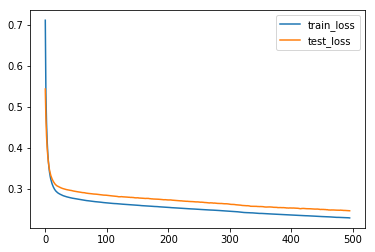

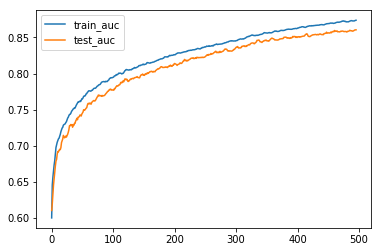

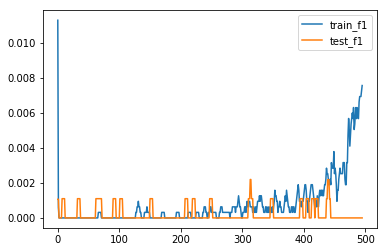

iter 550 train_loss 0.22588 test_loss 0.0054201
iter 550 train_f1 0.01412 test_f1 0.0054201

iter 600 train_loss 0.22247 test_loss 0.016129
iter 600 train_f1 0.02795 test_f1 0.016129

iter 650 train_loss 0.21974 test_loss 0.031915
iter 650 train_f1 0.04151 test_f1 0.031915

iter 700 train_loss 0.21723 test_loss 0.037234
iter 700 train_f1 0.06777 test_f1 0.037234

iter 750 train_loss 0.21513 test_loss 0.067708
iter 750 train_f1 0.08747 test_f1 0.067708

iter 800 train_loss 0.21187 test_loss 0.092308
iter 800 train_f1 0.11645 test_f1 0.092308

iter 850 train_loss 0.21073 test_loss 0.1005
iter 850 train_f1 0.12310 test_f1 0.1005

iter 900 train_loss 0.20850 test_loss 0.12808
iter 900 train_f1 0.14693 test_f1 0.12808

iter 950 train_loss 0.20636 test_loss 0.10553
iter 950 train_f1 0.18169 test_f1 0.10553

iter 1000 train_loss 0.20521 test_loss 0.15904
iter 1000 train_f1 0.16006 test_f1 0.15904



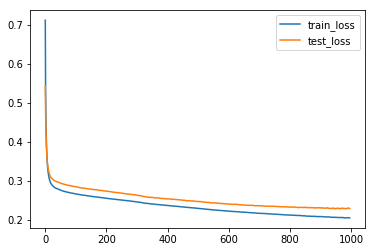

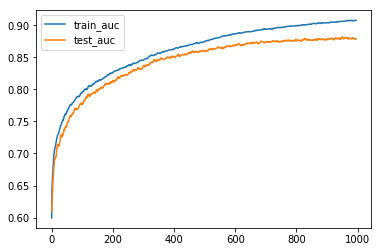

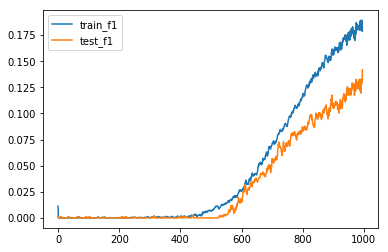

iter 1050 train_loss 0.20279 test_loss 0.15534
iter 1050 train_f1 0.20314 test_f1 0.15534

iter 1100 train_loss 0.20215 test_loss 0.1844
iter 1100 train_f1 0.20137 test_f1 0.1844

iter 1150 train_loss 0.20132 test_loss 0.19718
iter 1150 train_f1 0.20341 test_f1 0.19718

iter 1200 train_loss 0.19837 test_loss 0.20737
iter 1200 train_f1 0.22578 test_f1 0.20737

iter 1250 train_loss 0.19741 test_loss 0.17225
iter 1250 train_f1 0.26581 test_f1 0.17225

iter 1300 train_loss 0.19671 test_loss 0.15904
iter 1300 train_f1 0.28769 test_f1 0.15904

iter 1350 train_loss 0.19861 test_loss 0.24053
iter 1350 train_f1 0.21361 test_f1 0.24053

iter 1400 train_loss 0.19357 test_loss 0.17703
iter 1400 train_f1 0.30322 test_f1 0.17703

iter 1450 train_loss 0.19568 test_loss 0.26696
iter 1450 train_f1 0.23293 test_f1 0.26696

iter 1500 train_loss 0.19353 test_loss 0.28755
iter 1500 train_f1 0.24101 test_f1 0.28755



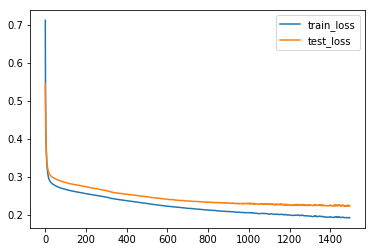

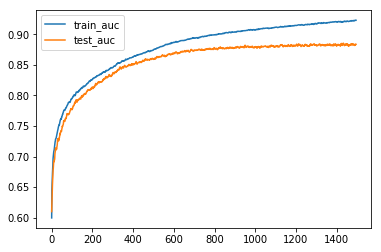

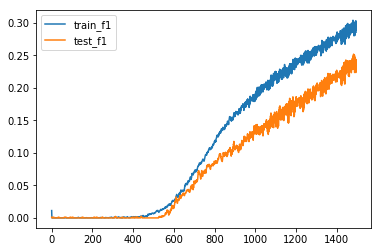

iter 1550 train_loss 0.19104 test_loss 0.28632
iter 1550 train_f1 0.26693 test_f1 0.28632

iter 1600 train_loss 0.19007 test_loss 0.28448
iter 1600 train_f1 0.27479 test_f1 0.28448

iter 1650 train_loss 0.18899 test_loss 0.28942
iter 1650 train_f1 0.27515 test_f1 0.28942

iter 1700 train_loss 0.18764 test_loss 0.30638
iter 1700 train_f1 0.28424 test_f1 0.30638

iter 1750 train_loss 0.18768 test_loss 0.32848
iter 1750 train_f1 0.27420 test_f1 0.32848

iter 1800 train_loss 0.18627 test_loss 0.19858
iter 1800 train_f1 0.38288 test_f1 0.19858

iter 1850 train_loss 0.18398 test_loss 0.2186
iter 1850 train_f1 0.38564 test_f1 0.2186

iter 1900 train_loss 0.18734 test_loss 0.33126
iter 1900 train_f1 0.27077 test_f1 0.33126

iter 1950 train_loss 0.18321 test_loss 0.30998
iter 1950 train_f1 0.31506 test_f1 0.30998

iter 2000 train_loss 0.18192 test_loss 0.33471
iter 2000 train_f1 0.31924 test_f1 0.33471



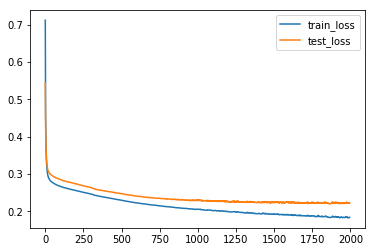

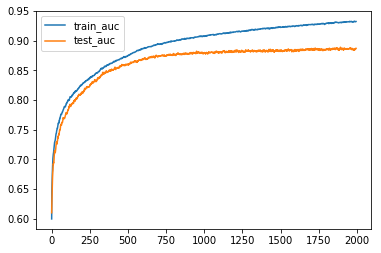

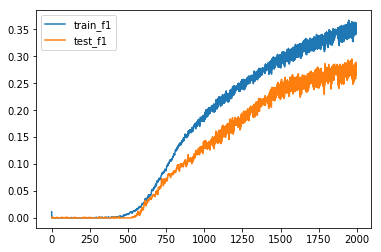

In [22]:
stats_noisy = train_model(model_noisy, X_train, y_train, X_test, y_test, batch_size=batch_size, iters=1000)

In [ ]:
train_model(model_noisy, X_train, y_train, X_test, y_test, batch_size=batch_size, iters=1000, stats=stats_noisy)

In [23]:
predicted_probality = RnnPredictor(model_noisy).predict_proba(X_test, device)

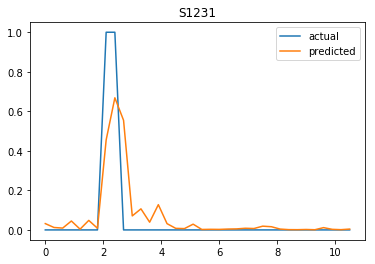

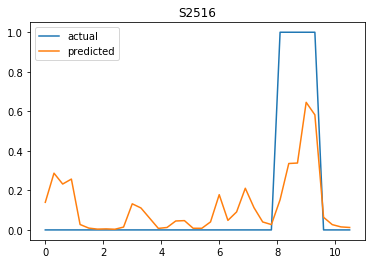

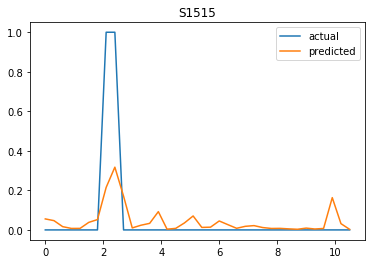

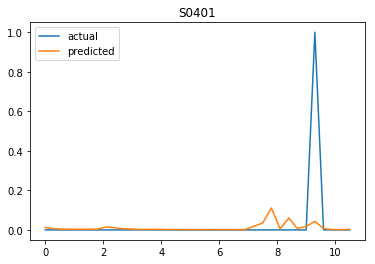

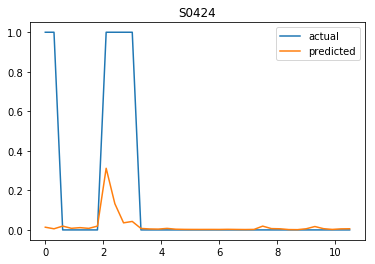

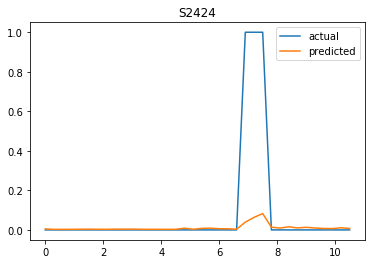

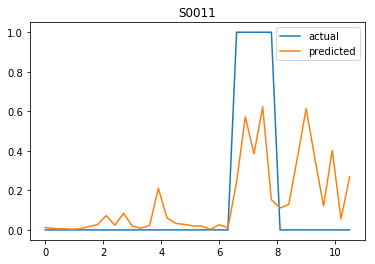

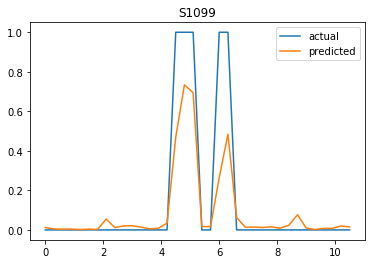

In [33]:
for sname, actual, pred in zip(snames_test[:32], y_test, predicted_probality):
    if np.sum(actual) != 0:
        plt.title(sname)
        l = len(actual)
        plt.plot(np.arange(l) * FRAME_SEC, actual, label='actual')
        plt.plot(np.arange(l) * FRAME_SEC, pred, label='predicted')
        plt.legend()
        plt.show()


## Обучаем модель на данных без добавленного шума

In [39]:
X_train, X_test, y_train, y_test, snames_train, snames_test = split(data)

In [40]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2461, 36, 148) (274, 36, 148) (2461, 36) (274, 36)


In [36]:
model_clean = LibrosaFeaturesRnn(fbank_features, mfcc_features, 
                           hidden_size=hidden_size,
                           batch_size=batch_size)

model_clean = model_clean.to(device)
train_iter = 1

iter 50 train_loss 0.27771 test_loss 0.0054945
iter 50 train_f1 0.00000 test_f1 0.0054945

iter 100 train_loss 0.26184 test_loss 0.0054945
iter 100 train_f1 0.00316 test_f1 0.0054945

iter 150 train_loss 0.25270 test_loss 0.0
iter 150 train_f1 0.00000 test_f1 0.0

iter 200 train_loss 0.24592 test_loss 0.0054795
iter 200 train_f1 0.00158 test_f1 0.0054795

iter 250 train_loss 0.24017 test_loss 0.0054201
iter 250 train_f1 0.00789 test_f1 0.0054201

iter 300 train_loss 0.23581 test_loss 0.021739
iter 300 train_f1 0.01876 test_f1 0.021739

iter 350 train_loss 0.23253 test_loss 0.032258
iter 350 train_f1 0.02644 test_f1 0.032258

iter 400 train_loss 0.22922 test_loss 0.037433
iter 400 train_f1 0.04012 test_f1 0.037433

iter 450 train_loss 0.22643 test_loss 0.042781
iter 450 train_f1 0.05640 test_f1 0.042781

iter 500 train_loss 0.22341 test_loss 0.058201
iter 500 train_f1 0.08982 test_f1 0.058201



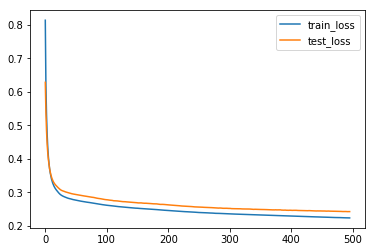

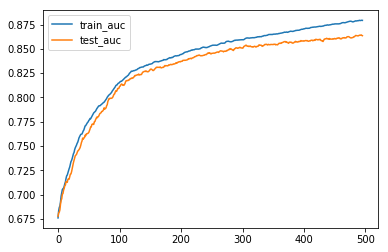

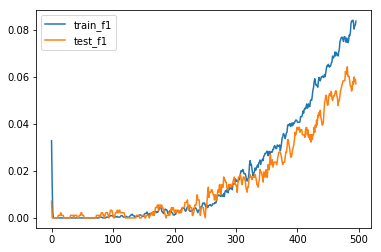

In [41]:
stats_сlean = train_model(model_clean, X_train, y_train, X_test, y_test, batch_size=batch_size, iters=1000)

iter 550 train_loss 0.22100 test_loss 0.078125
iter 550 train_f1 0.09111 test_f1 0.078125

iter 600 train_loss 0.21919 test_loss 0.082687
iter 600 train_f1 0.11739 test_f1 0.082687

iter 650 train_loss 0.21743 test_loss 0.096692
iter 650 train_f1 0.12308 test_f1 0.096692

iter 700 train_loss 0.21612 test_loss 0.105
iter 700 train_f1 0.12945 test_f1 0.105

iter 750 train_loss 0.21383 test_loss 0.12903
iter 750 train_f1 0.14582 test_f1 0.12903

iter 800 train_loss 0.21206 test_loss 0.13235
iter 800 train_f1 0.15363 test_f1 0.13235

iter 850 train_loss 0.21127 test_loss 0.14044
iter 850 train_f1 0.15887 test_f1 0.14044

iter 900 train_loss 0.21040 test_loss 0.17661
iter 900 train_f1 0.17355 test_f1 0.17661

iter 950 train_loss 0.20778 test_loss 0.18571
iter 950 train_f1 0.19350 test_f1 0.18571

iter 1000 train_loss 0.20798 test_loss 0.18396
iter 1000 train_f1 0.18910 test_f1 0.18396



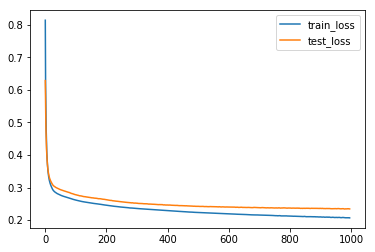

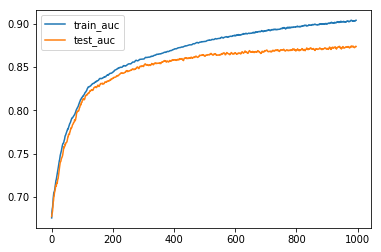

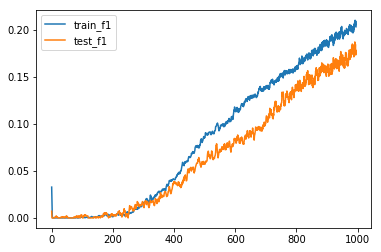

iter 1050 train_loss 0.20558 test_loss 0.20465
iter 1050 train_f1 0.20123 test_f1 0.20465

iter 1100 train_loss 0.20670 test_loss 0.24146
iter 1100 train_f1 0.20859 test_f1 0.24146

iter 1150 train_loss 0.20512 test_loss 0.23714
iter 1150 train_f1 0.22598 test_f1 0.23714

iter 1200 train_loss 0.20291 test_loss 0.22573
iter 1200 train_f1 0.23411 test_f1 0.22573

iter 1250 train_loss 0.20343 test_loss 0.25277
iter 1250 train_f1 0.22942 test_f1 0.25277

iter 1300 train_loss 0.20063 test_loss 0.2427
iter 1300 train_f1 0.24652 test_f1 0.2427

iter 1350 train_loss 0.20012 test_loss 0.23348
iter 1350 train_f1 0.25363 test_f1 0.23348

iter 1400 train_loss 0.19828 test_loss 0.25821
iter 1400 train_f1 0.26070 test_f1 0.25821

iter 1450 train_loss 0.19742 test_loss 0.25652
iter 1450 train_f1 0.27487 test_f1 0.25652

iter 1500 train_loss 0.19644 test_loss 0.25322
iter 1500 train_f1 0.27320 test_f1 0.25322



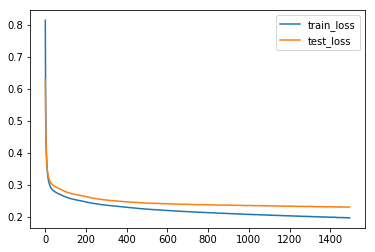

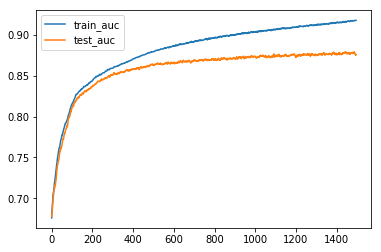

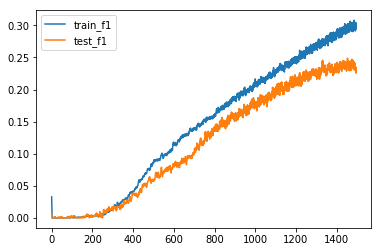

iter 1550 train_loss 0.19502 test_loss 0.26237
iter 1550 train_f1 0.28086 test_f1 0.26237

iter 1600 train_loss 0.19426 test_loss 0.26609
iter 1600 train_f1 0.29051 test_f1 0.26609

iter 1650 train_loss 0.19211 test_loss 0.25652
iter 1650 train_f1 0.30346 test_f1 0.25652

iter 1700 train_loss 0.19160 test_loss 0.26407
iter 1700 train_f1 0.32181 test_f1 0.26407

iter 1750 train_loss 0.19209 test_loss 0.27586
iter 1750 train_f1 0.30563 test_f1 0.27586

iter 1800 train_loss 0.18987 test_loss 0.29175
iter 1800 train_f1 0.30799 test_f1 0.29175

iter 1850 train_loss 0.19073 test_loss 0.29461
iter 1850 train_f1 0.32238 test_f1 0.29461

iter 1900 train_loss 0.18821 test_loss 0.29412
iter 1900 train_f1 0.33480 test_f1 0.29412

iter 1950 train_loss 0.18843 test_loss 0.30705
iter 1950 train_f1 0.32538 test_f1 0.30705

iter 2000 train_loss 0.18816 test_loss 0.31056
iter 2000 train_f1 0.33144 test_f1 0.31056



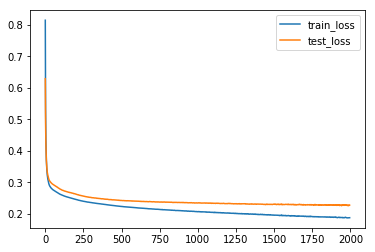

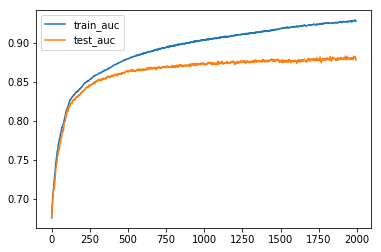

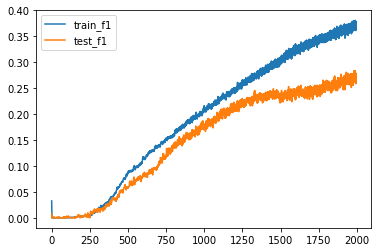

In [43]:
train_model(model_clean, X_train, y_train, X_test, y_test, batch_size=batch_size, iters=1000, stats=stats_сlean)

## Сравнение моделей

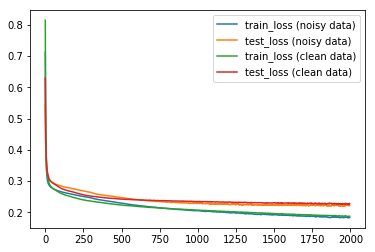

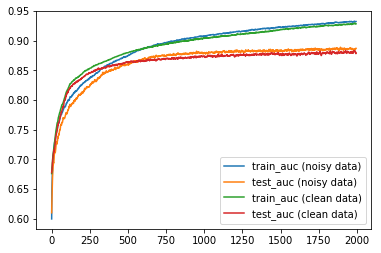

In [46]:
plt.plot(window_mean(stats_noisy.train_losses), label='train_loss (noisy data)')
plt.plot(window_mean(stats_noisy.test_losses), label='test_loss (noisy data)')
plt.plot(window_mean(stats_сlean.train_losses), label='train_loss (clean data)')
plt.plot(window_mean(stats_сlean.test_losses), label='test_loss (clean data)')

plt.legend()
plt.show()

plt.plot(window_mean(stats_noisy.train_auc), label='train_auc (noisy data)')
plt.plot(window_mean(stats_noisy.test_auc), label='test_auc (noisy data)')
plt.plot(window_mean(stats_сlean.train_auc), label='train_auc (clean data)')
plt.plot(window_mean(stats_сlean.test_auc), label='test_auc (clean data)')
plt.legend()
plt.show()

In [ ]:
scores_noisy = predicted_probality

In [ ]:
_, X_test_noisy, _, y_test_noisy, _, _ = split(data_noisy)

In [ ]:
scores_clean = RnnPredictor(model_clean).predict_proba(X_test_noisy, device)